# Training delle SVM
In this notebook we'll train a different SVM for each Action Unit (AU) that we want to classify.

### Part I
0. AU theory 
1. Extraction of an example (frame, label) from the dataset CK+
2. Partition of a group of examples in Positive and Negative examples, based on the presence of one of the AU
3. PCA model fitting
4. SVM model training, with K-Fold validation for the hyperparameter C

### Part II
For each AU that we want to classify, we'll execute these operations:
1. Pick a frame from one of the datasets
2. Pick the label associated to this frame. The label contains the AUs which are in that frame
3. We extract the HOG feature of the frame. If the AU we are considering is in the label, so we add the HOG feature to the Positive examples list. To this example will be associated the label 1 (True). Otherwise, we add the HOG feature to the Negative examples list and we associate the label 0 (False) to it. We implement this step in a way which allows us to have two list (Positive and Negative) of equal length.
4. Split the data in Training and Test sets
5. PCA model fitting with the Training set data. Then, with this model we'll transform the data in Training and Test sets. The PCA will be applied also to new data before we pass them to the classifier.
6. Training of the SVM model relative to the AU we are considering
7. Save the models

***

# Part I

Facial action coding system.
<img src="images/AU.png" width="400">

Emotion expressed as combination of AUs.

<img src="images/emotions.png">

<br>

Helper functions useful to scan the datasets.

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def show_gray_image_from_path(path):
    img = mpimg.imread(path)    
    imgplot = plt.imshow(img, cmap=plt.cm.gray)
    plt.show()
    
def change_extension_to_txt(text):
    return text[:-4] + "_facs.txt"
    
def get_aus(label_path, subpath):
    img_aus = list()  # AUs list of the image
    fname = "{}/{}".format(label_path, change_extension_to_txt(subpath))
    if os.path.isfile(fname):  # if the file exists
        f = open(fname,"r") 
        for line in f: 
            img_aus.append(int(float(line.split()[0])))
    return img_aus

<br>
Scanning of the CK+ dataset. We pick an image with the associated AUs (there isn't any AU in this example).

dataset/CK+/cohn-kanade-images/S005/001/S005_001_00000001.png
AU: []


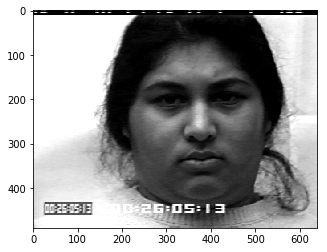

In [4]:
import os
from face_helpers import get_face_locations, get_landmarks, align_and_crop, get_hog_features, show_gray_image, show_image_from_path
import numpy as np

frame_path = "dataset/CK+/cohn-kanade-images"
label_path = "dataset/CK+/FACS"
counter = 0

for dir in os.listdir(frame_path):
    for subdir in os.listdir("{}/{}".format(frame_path, dir)):
        if not subdir.startswith('.'):
            for frame in os.listdir("{}/{}/{}".format(frame_path, dir, subdir)):
                if frame.endswith(".png") and counter < 1:
                    counter += 1
                    print("{}/{}/{}/{}".format(frame_path, dir, subdir, frame))
                    print("AU: {}".format(get_aus(label_path, "{}/{}/{}".format(dir, subdir, frame))))
                    show_gray_image_from_path("{}/{}/{}/{}".format(frame_path, dir, subdir, frame))

<br>
Example which present some AUs.

dataset/CK+/cohn-kanade-images/S005/001/S005_001_00000011.png
AU: [9, 17]


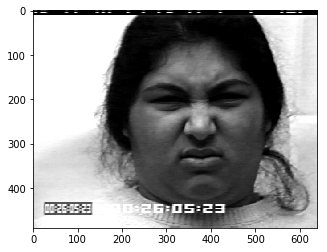

In [3]:
print("dataset/CK+/cohn-kanade-images/S005/001/S005_001_00000011.png")
print("AU: {}".format(get_aus(label_path, "S005/001/S005_001_00000011.txt"))) 
show_gray_image_from_path("dataset/CK+/cohn-kanade-images/S005/001/S005_001_00000011.png")

<br>
We divide a group of images based on the presence of the AU27. 
To balance the Positive and the Negative lists, we'll extract a negative example only if the Positive list is greater than the Negative one.  <br>

We have:
* a feature matrix 156 x 6084, in which each row contains the  HOG features of a single frame 
* a landmark matrix 156 x 144, in which each row contains the unpacked position (two elements instead of a couple) of each landmark of a single frame
* a list with the labels associated to these 156 images

Note: actually, in CK+ dataset there are 81 images with AU27, but we have to discard the frames for which we can't find the landmarks position. For this reason the feature matrix has 156 rows instead of 162.


In [6]:
def get_flatten_landmarks(landmarks):
    # From the landmarks list (which contains a dict with the features) we obtain a flat array
    lista_landmarks = list()
    for el in landmarks[0].values():
        lista_landmarks.append(el)
    return np.asarray([el for sublist in lista_landmarks for item in sublist for el in item])
    

def apply_pipeline(path, return_hog_image=False):
    img = get_face_locations(path, verbose=False)
    landmarks, _ = get_landmarks(img)
    img = align_and_crop(img, landmarks)
    landmarks, _ = get_landmarks(img)
    if len(landmarks) == 0:  # it can't find landmarks, so we don't consider this example
        landmarks = []
    else:
        landmarks = get_flatten_landmarks(landmarks)
    return (get_hog_features(img, flat_vector=True, return_image=return_hog_image), landmarks)

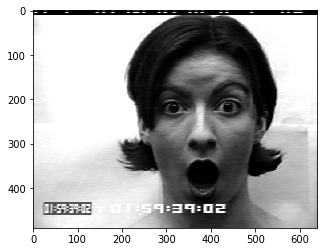

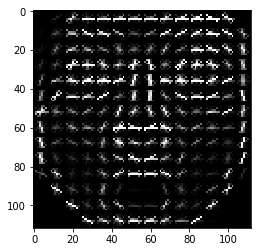

dataset/CK+/cohn-kanade-images/S010/002/S010_002_00000014.png     1
AU: [1, 2, 5, 25, 27]
-------------------------------------------------------------------
dataset/CK+/cohn-kanade-images/S014/001/S014_001_00000029.png     2
AU: [1, 2, 5, 12, 25, 27]
-------------------------------------------------------------------
dataset/CK+/cohn-kanade-images/S022/001/S022_001_00000030.png     3
AU: [1, 2, 25, 27]
-------------------------------------------------------------------
...
Feature matrix shape:   (156, 6084)
Landmark matrix shape:  (156, 144)
Number of labels:       156


In [132]:
au = 27
aus_list = list()
feature_list = list()
landmark_list = list()
labels = list()
count_positive = 0
count_negative = 0

for dir in os.listdir(frame_path):
    for subdir in os.listdir("{}/{}".format(frame_path, dir)):
        if not subdir.startswith('.'):
            for frame in os.listdir("{}/{}/{}".format(frame_path, dir, subdir)):
                if frame.endswith(".png"):
                    aus_list = get_aus(label_path, "{}/{}/{}".format(dir, subdir, frame))                    
                    if au in aus_list:  
                        if count_positive == 0:
                            (fd, hog_image), landmarks = apply_pipeline("{}/{}/{}/{}".format(frame_path, dir, subdir, frame), return_hog_image=True)
                            show_gray_image_from_path("{}/{}/{}/{}".format(frame_path, dir, subdir, frame))
                            show_gray_image(hog_image)
                        else:
                            fd, landmarks = apply_pipeline("{}/{}/{}/{}".format(frame_path, dir, subdir, frame))
                            
                        if len(landmarks) > 0:
                            if count_positive < 3:
                                print("{}/{}/{}/{}     {}".format(frame_path, dir, subdir, frame, count_positive+1))
                                print("AU: {}".format(aus_list))
                                print("-------------------------------------------------------------------")
                            if count_positive == 3:
                                print("...\n")
                                
                            count_positive += 1
                            feature_list.append(fd)
                            landmark_list.append(landmarks)
                            labels.append(1)
                    
                    else:
                        if count_positive > count_negative:
                            fd, landmarks = apply_pipeline("{}/{}/{}/{}".format(frame_path, dir, subdir, frame))
                            if len(landmarks) > 0:
                                count_negative += 1
                                feature_list.append(fd)
                                landmark_list.append(landmarks)
                                labels.append(0) 
                    
feature_list = np.asarray(feature_list)
landmark_list = np.asarray(landmark_list)
print("Feature matrix shape:  ", feature_list.shape)
print("Landmark matrix shape: ", landmark_list.shape)
print("Number of labels:      ", len(labels))

<br>
We concatenate the Feature matrix with the Landmark matrix and then we split the data in Training and Test sets.
So, we obtain a single matrix with shape (156, 6228) which is divided in Training set and Test set.

In [133]:
from sklearn import model_selection
concatenation = np.concatenate((feature_list, landmark_list), axis=1)
X_train, X_test, y_train, y_test = model_selection.train_test_split(concatenation, labels, test_size=0.2, random_state=0)

print("X_train: {} \nX_test: {}".format(X_train.shape, X_test.shape))

X_train: (124, 6228) 
X_test: (32, 6228)


<br>
Now, we want to apply the PCA only to the feature data in our sets and not to the landmarks position. So we use the PCA only considering the first 6084 columns of the data. Our aim is to reduce the number of columns. <br>
In this example we obtain 103 columns, starting from 6084.
So at the end we will have 103 + 144 = 247 columns.

In [136]:
from sklearn.decomposition import PCA

last = len(feature_list[0])  # = 6084

# PCA model fitting
pca = PCA(n_components=.95)
pca.fit(X_train[:,:last])    

# PCA applied to the Training and Test set
X_train_pca = pca.transform(X_train[:,:last])
X_test_pca = pca.transform(X_test[:,:last])
X_train_pca = np.concatenate((X_train_pca, X_train[:, last:]), axis=1)
X_test_pca = np.concatenate((X_test_pca, X_test[:, last:]), axis=1)

print("X_train: {} \nX_test: {}".format(X_train_pca.shape, X_test_pca.shape))

X_train: (124, 247) 
X_test: (32, 247)


<br>
Check if it is all right. 

In [137]:
print("First landmarks position (Training set): ({}, {}) = ({}, {})"\
      .format(X_train[0,6084], X_train[0,6085], X_train_pca[0,103], X_train_pca[0,104])) # note that 247 - 144 = 103
print("Last landmarks position  (Training set): ({}, {}) = ({}, {})"\
      .format(X_train[0,6226], X_train[0,6227], X_train_pca[0,245], X_train_pca[0,246]))

First landmarks position (Training set): (2.0, 27.0) = (2.0, 27.0)
Last landmarks position  (Training set): (68.0, 86.0) = (68.0, 86.0)


<br>

Validation of the SVM hyperparameters C and Gamma, based on [this tutorial](http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/auto_examples/svm/plot_svm_parameters_selection.html).

In [108]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVC

# We scale the data
scaler = StandardScaler()
scaler.fit(X_train_pca)
X_train_pca = scaler.transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)

# Grid Search
# Parameter Grid
param_grid = {'C': [100, 10, 1, 0.1], 'gamma': [0.001, 0.01]}

 
# Make grid search classifier
clf_grid = GridSearchCV(SVC(), param_grid, verbose=1, cv=5, n_jobs=-1)
 
# Train the classifier
clf_grid.fit(X_train_pca, y_train)
 
print("Best Parameters:     ", clf_grid.best_params_)
#print("Best Estimators:     ", clf_grid.best_estimator_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters:      {'C': 100, 'gamma': 0.001}


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.2s finished


{'C': 100, 'gamma': 0.001} -> Average Score: 0.99


c:\users\luca\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


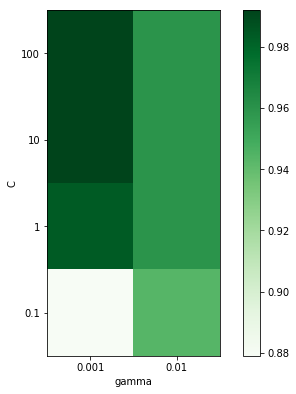

In [111]:
# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
score_dict = clf_grid.grid_scores_

# We extract just the scores
scores = [x[1] for x in score_dict]
scores = np.array(scores).reshape(len(param_grid['C']), len(param_grid['gamma']))

print("{0} -> Average Score: {1:.2f}".format(clf_grid.best_params_, scores.max()))

# Make a nice figure
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.Greens)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'])
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.show()

<br>
SVM training.

In [112]:
#from sklearn.svm import SVC

clf = clf_grid.best_estimator_
clf.fit(X_train_pca, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

<br>
We implement a function in order to compute Training and Test accuracies.

In [113]:
def get_accuracy(predicted_labels, true_labels):
    counter_ok = 0.0
    for i in range(len(predicted_labels)):
        if predicted_labels[i] == true_labels[i]:
            counter_ok += 1
    return counter_ok

<br>
Testing.

In [114]:
predicted_labels = clf.predict(X_test_pca)               
counter_ok = get_accuracy(predicted_labels, y_test)
print("Test Score  -> {0}/{1} = {2:.2f} %"\
      .format(int(counter_ok), len(predicted_labels), (counter_ok / len(predicted_labels)*100)))

predicted_labels = clf.predict(X_train_pca)
counter_ok = get_accuracy(predicted_labels, y_train)
print("Train Score -> {0}/{1} = {2:.2f} %"\
      .format(int(counter_ok), len(predicted_labels), (counter_ok / len(predicted_labels)*100)))

Test Score  -> 32/32 = 100.00 %
Train Score -> 124/124 = 100.00 %


<br>
Testing of the classifier on an image (with the AU27) which is not in the CK+ dataset. <br>
Note that we have to apply the PCA only on the HOG features of the image, while the scaler must be applied to the HOG features concatenated with the landmarks position.

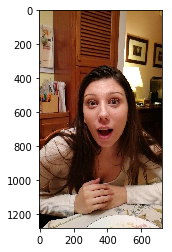

feature vector shape:  (1, 247)
A27:  True


In [126]:
labels_dict = {0: "False", 1: "True"}

show_image_from_path("images/test_au27.jpg")
fd, lm = apply_pipeline("images/test_au27.jpg")
fd = pca.transform(fd.reshape(1,-1))
fd = np.concatenate((fd[0,:], lm)).reshape(1,-1)
fd = scaler.transform(fd)

print("feature vector shape: ", fd.shape)
print("A27: ", labels_dict[clf.predict(fd)[0]])

<br>
Testing with an image which doesn't contain AU27.

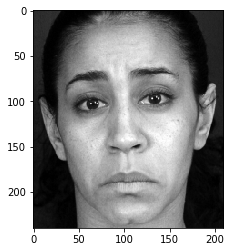

feature vector shape:  (1, 247)
A27:  False


In [127]:
show_image_from_path("images/test_sadness.jpg")
fd, lm = apply_pipeline("images/test_sadness.jpg")
fd = pca.transform(fd.reshape(1,-1))
fd = np.concatenate((fd[0,:], lm)).reshape(1,-1)
fd = scaler.transform(fd)

print("feature vector shape: ", fd.shape)
print("A27: ", labels_dict[clf.predict(fd)[0]])

<br>
We implement two functions in order to save and load a model (PCA, Scaler, SVM).

In [8]:
from sklearn.externals import joblib
models_path = "models"

def save_model(model, name):
    joblib.dump(model, "{}/{}".format(models_path, name))
    
def load_model(name):
    return joblib.load("{}/{}".format(models_path, name))

In [129]:
save_model(clf, "svm_test")
loaded_clf = load_model("svm_test")
print("A27: ", labels_dict[clf.predict(fd)[0]])
print("A27: ", labels_dict[loaded_clf.predict(fd)[0]])

A27:  False
A27:  False


***

# Part II
We apply the same procedure of the Part I for each AU we want to classify. We'll consider data extracted from different dataset. 

In [130]:
def add_data(au, feature_list, landmark_list, labels, frame_path, label_path):
    aus_list = list()
    global count_positive
    global count_negative

    for dir in os.listdir(frame_path):
        for subdir in os.listdir("{}/{}".format(frame_path, dir)):
            if not subdir.startswith('.'):
                for frame in os.listdir("{}/{}/{}".format(frame_path, dir, subdir)):
                    if frame.endswith(".png"):
                        aus_list = get_aus(label_path, "{}/{}/{}".format(dir, subdir, frame))                    
                        if au in aus_list:  
                            try:
                                fd, landmarks = apply_pipeline("{}/{}/{}/{}".format(frame_path, dir, subdir, frame))
                                if len(landmarks) > 0:
                                    count_positive += 1
                                    feature_list.append(fd)
                                    landmark_list.append(landmarks)
                                    labels.append(1)
                            except:
                                pass
                        
                        else:
                            if count_positive > count_negative:
                                try:
                                    fd, landmarks = apply_pipeline("{}/{}/{}/{}".format(frame_path, dir, subdir, frame))
                                    if len(landmarks) > 0:
                                        count_negative += 1
                                        feature_list.append(fd)
                                        landmark_list.append(landmarks)
                                        labels.append(0)
                                except:
                                    pass

In [147]:
import csv

aus = [1, 2, 4, 5, 6, 7, 9, 12, 14, 15, 16, 20, 23, 26]
#aus = [1, 15]
scaler = StandardScaler()
file = open("scores.csv", 'a', newline='')
wr = csv.writer(file)

# Parameters Grid used in OpenFace:
#      - C = [10.^(-7:0.5:1);]
#      - Gamma = [0.001]
param_grid = {'C': [100, 10, 1], 'gamma': [0.001]}
cv = KFold(n_splits=5, shuffle=True)


for au in aus:
    print("AU: ", au)
    count_positive = 0
    count_negative = 0
    feature_list = list()
    landmark_list = list()
    labels = list()
    print("     - Add data from {}...".format("CK+"))
    add_data(au, feature_list, landmark_list, labels, frame_path = "dataset/CK+/cohn-kanade-images", label_path = "dataset/CK+/FACS") 
    print("     - Add data from {}...".format("UNBC"))
    add_data(au, feature_list, landmark_list, labels, frame_path = "dataset/UNBC-pain/Images", label_path = "dataset/UNBC-pain/Frame_Labels/FACS")
    feature_list = np.asarray(feature_list)
    landmark_list = np.asarray(landmark_list)
    print("          Feature matrix shape:  ", feature_list.shape)
    print("          Landmark matrix shape: ", landmark_list.shape)
    print("          Number of labels:      ", len(labels))
    
    
    print("     - Split data in Training and Test sets...")
    concatenation = np.concatenate((feature_list, landmark_list), axis=1)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(concatenation, labels, test_size=0.2, random_state=0)
    print("          X_train: {} \n          X_test:  {}".format(X_train.shape, X_test.shape))
    
    
    print("     - PCA transformation...")
    last = len(feature_list[0])
    pca = PCA(n_components=.95)
    pca.fit(X_train[:,:last])
    X_train_pca = pca.transform(X_train[:,:last])
    X_test_pca = pca.transform(X_test[:,:last])
    X_train_pca = np.concatenate((X_train_pca, X_train[:, last:]), axis=1)
    X_test_pca = np.concatenate((X_test_pca, X_test[:, last:]), axis=1)
    print("          X_train: {} \n          X_test:  {}".format(X_train_pca.shape, X_test_pca.shape))
    
    
    print("     - K-Fold Validation for the hyperparameter C...")
    scaler = StandardScaler()
    scaler.fit(X_train_pca)
    X_train_pca = scaler.transform(X_train_pca)
    X_test_pca = scaler.transform(X_test_pca)
    clf_grid = GridSearchCV(SVC(), param_grid, cv=cv, n_jobs=-1)
    clf_grid.fit(X_train_pca, y_train)
    print("          Best Parameters: ", clf_grid.best_params_)
    
    
    print("     - SVM training...")
    clf = clf_grid.best_estimator_
    clf.fit(X_train_pca, y_train)
    
    predicted_labels = clf.predict(X_test_pca)               
    counter_ok_test = get_accuracy(predicted_labels, y_test)
    len_test = len(predicted_labels)
    test_score = round((counter_ok_test / len_test*100), 2)
    print("          Test Score  -> {0}/{1} = {2:.2f} %"\
          .format(int(counter_ok_test), len_test, test_score))

    predicted_labels = clf.predict(X_train_pca)
    counter_ok_train = get_accuracy(predicted_labels, y_train)
    len_train = len(predicted_labels)
    train_score = round((counter_ok_train / len_train*100), 2)
    print("          Train Score -> {0}/{1} = {2:.2f} %"\
          .format(int(counter_ok_train), len_train, train_score))

    #wr.writerow(["model", "count_ok_train", "count_tot_train", "train_score", "count_ok_test", "count_tot_test", "test_score"])
    wr.writerow(["svm_au{}".format(au), int(counter_ok_train), len_train, train_score, int(counter_ok_test), len_test, test_score])
    
    print("     - Save the models...")
    save_model(pca, "pca_au{}-svm".format(au))
    save_model(clf, "svm_au{}".format(au))
    save_model(scaler, "scaler_au{}-svm".format(au))
    print("--------------------------------------------------------")
    
file.close()

AU:  1
     - Add data from CK+...
     - Add data from UNBC...
          Feature matrix shape:   (336, 6084)
          Landmark matrix shape:  (336, 144)
          Number of labels:       336
     - Division of data in Training and Test sets...
          X_train: (268, 6228) 
          X_test:  (68, 6228)
     - PCA transformation...
          X_train: (268, 350) 
          X_test:  (68, 350)
     - K-Fold Validation for the hyperparameter C...
          Best Parameters:  {'C': 100, 'gamma': 0.001}
     - SVM training...
          Test Score  -> 62/68 = 91.18 %
          Train Score -> 268/268 = 100.00 %
     - Save the models...
--------------------------------------------------------
AU:  2
     - Add data from CK+...
     - Add data from UNBC...
          Feature matrix shape:   (226, 6084)
          Landmark matrix shape:  (226, 144)
          Number of labels:       226
     - Division of data in Training and Test sets...
          X_train: (180, 6228) 
          X_test:  (46, 62

          Test Score  -> 290/309 = 93.85 %
          Train Score -> 1233/1233 = 100.00 %
     - Save the models...
--------------------------------------------------------
AU:  23
     - Add data from CK+...
     - Add data from UNBC...
          Feature matrix shape:   (118, 6084)
          Landmark matrix shape:  (118, 144)
          Number of labels:       118
     - Division of data in Training and Test sets...
          X_train: (94, 6228) 
          X_test:  (24, 6228)
     - PCA transformation...
          X_train: (94, 223) 
          X_test:  (24, 223)
     - K-Fold Validation for the hyperparameter C...
          Best Parameters:  {'C': 100, 'gamma': 0.001}
     - SVM training...
          Test Score  -> 19/24 = 79.17 %
          Train Score -> 94/94 = 100.00 %
     - Save the models...
--------------------------------------------------------
AU:  26
     - Add data from CK+...
     - Add data from UNBC...
          Feature matrix shape:   (4178, 6084)
          Landmark matr

<br>
Test Accuracy and Training Accuracy.

In [149]:
with open('scores.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if row[0][:3] == "svm":
            print("{}:\n     Test Score  -> {}/{} = {} %\n     Train Score -> {}/{} = {} %\n"\
                 .format(row[0], row[4], row[5], row[6], row[1], row[2], row[3]))

svm_au1:
     Test Score  -> 62/68 = 91.18 %
     Train Score -> 268/268 = 100.0 %

svm_au2:
     Test Score  -> 42/46 = 91.3 %
     Train Score -> 180/180 = 100.0 %

svm_au4:
     Test Score  -> 398/429 = 92.77 %
     Train Score -> 1715/1715 = 100.0 %

svm_au5:
     Test Score  -> 36/40 = 90.0 %
     Train Score -> 158/158 = 100.0 %

svm_au6:
     Test Score  -> 1909/2041 = 93.53 %
     Train Score -> 8158/8160 = 99.98 %

svm_au7:
     Test Score  -> 1208/1292 = 93.5 %
     Train Score -> 5164/5165 = 99.98 %

svm_au9:
     Test Score  -> 163/176 = 92.61 %
     Train Score -> 702/702 = 100.0 %

svm_au12:
     Test Score  -> 2399/2549 = 94.12 %
     Train Score -> 10188/10195 = 99.93 %

svm_au14:
     Test Score  -> 15/15 = 100.0 %
     Train Score -> 59/59 = 100.0 %

svm_au15:
     Test Score  -> 28/39 = 71.79 %
     Train Score -> 155/155 = 100.0 %

svm_au16:
     Test Score  -> 9/10 = 90.0 %
     Train Score -> 36/36 = 100.0 %

svm_au20:
     Test Score  -> 290/309 = 93.85 %
     Tr

<br>
AU2 test.

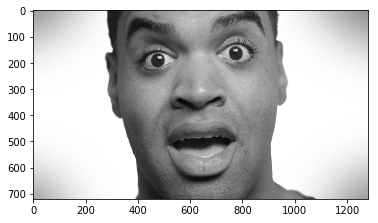

feature vector shape:  (1, 290)
AU2 :  True


In [11]:
show_image_from_path("images/test_au2.jpg")
fd, lm = apply_pipeline("images/test_au2.jpg")
pca = load_model("pca_au2-svm")
scaler = load_model("scaler_au2-svm")
loaded_clf = load_model("svm_au2")

fd = pca.transform(fd.reshape(1,-1))
fd = np.concatenate((fd[0,:], lm)).reshape(1,-1)
fd = scaler.transform(fd)

print("feature vector shape: ", fd.shape)
print("AU2 : ", labels_dict[loaded_clf.predict(fd)[0]])

***